# Example – Heat Transfer

## Introduction

Fire Dynamics Simulator (FDS) calculates the mechanisms of heat transfer taking into account the corresponding physical processes of convection and radiation. From the resulting heat flow onto a solid surface, the surface temperature as well as the temperature at a certain depth can be determined, taking into account the material properties and the the respective boundary conditions. By default, FDS  only performs a transient, one-dimensional calculation of heat transfer. The objective of this exercise is to discuss the different influences of radiation and convection as well as the surface and material properties of a solid body on its heating. in case of fire. The ({download}`HeatTransfer.fds`) input file which is similar to the simple **[Plume fire](./modelling/03_compartments/03_pool_example)** from Chapter 3.2 can be used as a starting point.

## Setup

:::{figure-md} fig-pool-fire-smv-plain

<img src="figs/fds.png" width="100%">

SMV visualization of the geometry. The surface patch `BURNER`, which has a `HRRPUA` defined, is colored redish.  
:::

## Tasks

1. Calculate and evaluate the Adiabatic Surface Temperature (AST), the  Adiabatic Surface Temperature Gas (AST Gas), as well as the Surface Temperature for the individual target surfaces and compare them to each other.


2. Calculate and evaluate the inside wall temperature for the uncovered target surface taking into account constant and temperature dependent thermal material properties.


3. Calculate and evaluate the surface temperature as well as the inside wall temperature for different backing types:
    - void
    - insulated

In [1]:
import fdsreader
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 1

root = '../../../../'

In [2]:

slice_temp = sim.slices[0]
time = 20
time_index = slice_temp.get_nearest_timestep(time)

plt.figure(figsize=(4,6))
plt.imshow(slice_temp[0].data[time_index].T, origin='lower', 
           extent=slice_temp[0].extent.as_list(), cmap='jet',
           vmin=20, vmax=1200)
plt.xlabel("X / m")
plt.ylabel("Z / m")
plt.colorbar(label="Temperature / $\sf ^\circ C$")
plt.savefig('figs/pool_fire_1mw_temperatures_slice.svg', bbox_inches='tight')
plt.close()

In [141]:
data_root = root + 'data/heat_transfer/heat_transfer'
sim = fdsreader.Simulation(data_root)
time = sim.devices['Time'].data
# steel_front = sim.devices['Temp_steel_top_front'].data
# steel_back = sim.devices['Temp_steel_top_back'].data
steel_exposed_front = sim.devices['Steel_exposed_front'].data
steel_exposed_020 = sim.devices['Steel_exposed_020'].data
steel_exposed_040 = sim.devices['Steel_exposed_040'].data
steel_exposed_060 = sim.devices['Steel_exposed_060'].data
steel_exposed_080 = sim.devices['Steel_exposed_080'].data
steel_exposed_back = sim.devices['Steel_exposed_back'].data

steel_insulated_front = sim.devices['Steel_insulated_front'].data
steel_insulated_020 = sim.devices['Steel_insulated_020'].data
steel_insulated_040 = sim.devices['Steel_insulated_040'].data
steel_insulated_060 = sim.devices['Steel_insulated_060'].data
steel_insulated_080 = sim.devices['Steel_insulated_080'].data
steel_insulated_back = sim.devices['Steel_insulated_back'].data


No handles with labels found to put in legend.


[ 0.0000000e+00 -1.1590250e-02 -1.3303006e-01 ...  1.6939896e+01
  1.6959976e+01  1.6965584e+01]


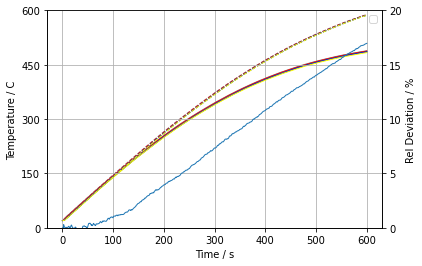

<Figure size 720x720 with 0 Axes>

In [217]:
# plt.plot(time, steel_010, label="10 mm")
# plt.plot(time, steel_front, label="front")
# plt.plot(time, steel_back, label="back")
fig, ax1 = plt.subplots()

ax1.plot(time, steel_exposed_front, label="Front exposed", color='gray')
ax1.plot(time, steel_exposed_020, label="20 mm exposed", color='red')
ax1.plot(time, steel_exposed_040, label="40 mm exposed", color='green')
ax1.plot(time, steel_exposed_060, label="60 mm exposed", color='blue')
ax1.plot(time, steel_exposed_080, label="80 mm exposed", color='yellow')

ax1.plot(time, steel_insulated_front, label="Front insulated", color='gray', linestyle='--')
ax1.plot(time, steel_insulated_020, label="20 mm insulated", color='red', linestyle='--')
ax1.plot(time, steel_insulated_040, label="40 mm insulated", color='green', linestyle='--')
ax1.plot(time, steel_insulated_060, label="60 mm insulated", color='blue', linestyle='--')
ax1.plot(time, steel_insulated_080, label="80 mm insulated", color='yellow', linestyle='--')

error = (steel_insulated_front-steel_exposed_front)/steel_insulated_front*100
ax2 = ax1.twinx()
ax2.plot(time, error)
# plt.xlim(0,600)
# plt.ylim(20,600)

# plt.xlim(0,10)
# plt.ylim(20,35)
ax1.set_ylim(0,600)
ax2.set_ylim(0,20)

plt.legend(loc='upper right',ncol=2)
ax1.grid(axis='x')
ax1.set_xlabel("Time / s")
ax1.set_ylabel("Temperature / C")
ax2.set_ylabel("Rel Deviation / %")
ax1.set_yticks(np.linspace(0,600,5))
ax2.set_yticks(np.linspace(0,20,5))
plt.grid(axis='y')
plt.figure(figsize=(10,10))

plt.savefig('figs/backings_end.svg')
print(error)

## SMV Visualisation

The computational domain including boundary conditions, obstructions and the results for the respective output variables of the FDS simulation can be displayed with the Smokeview post-processor.

:::{figure-md} fig-pool-fire-smv-plain

<img src="figs/pool_fire_all.png" width="100%">

SMV visualization of the geometry / the mesh-grid in the y-z-plane / the temperature values in the y-z-slice at  $\sf y=0~m$ ($\sf t=19.63~s$). The surface patch `BURNER`, which has a `HRRPUA` defined, is colored redish.  
:::

## Analysis

The following tasks are intended to provide a general understanding of how to use FDS and SmokeView. They cover the basic functions and the analysis of the simulation results. The FDS input case described above can serve as a starting point.

```{tip} Read the entire task before starting a simulation to capture multiple output parameters in a single run. 
```

## Task I – Basics

The goal of this task is to become familiar with basic functions. Use the above listed input file and extend it to your needs. 

```{tip} When adding new diagnostics or other elements, it is useful to reduce the computing time to allow for a fast turn-over-time. This way debugging or adjusting your setup will be more efficient. For pure geometrical checks, the simulation time can also be set to zero.  
```


**Task:**

1. Add a temperature slice at $\small\sf y=0~m$ and watch the output via smokeview. Change the output by varying the color scaling and crop the data at an upper and lower boundary. Create snapshots for three points in time, e.g. $\small\sf 5~s$, $\small\sf 10~s$ and $\small\sf 20~s$. Add appropriate axes labels to the smokeview output to check the slice orientation. Refer to section 5.2 "Data Bounds" and 14.4 "TICKS and LABEL keywords" of [Smokeview User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.6/SMV_User_Guide.pdf) for more information on how to change the output properties of slices. 

2. Visualize the velocity vector field in the plume axis at $\small\sf t \approx 20~s$ for $\small\sf y=0~m$.
    * Extra task: Open the sealed domain on at least one side and observe the change in the flow field. 

3. Plot the computed heat release rate (HRR) from the pool_fire_hrr.csv file against the given input HRR of the FDS file. Discuss the differences and what these are related to. Run simulations for HRR of $\small\sf 100~kW$, $\small\sf 1~MW$ and $\small\sf 10~MW$.

**1. Solution**

:::{figure-md} fig-pool-fire-temp-timesteps

<img src="figs/pool_fire_temp_timesteps.png" width="100%">

Visualization of the instantaneous `TEMPERATURE` values in the x-z-level at $\sf y=0~m$ for different timesteps ($\sf t=5.03~s$), ($\sf t=10.03~s$), ($\sf t=20.03~s$) The attribute `CELL_CENTERED`, prevents the values between the cell boundaries from being interpolated.
:::

:::{figure-md} fig-pool-fire-temp-bounds-trunc

<img src="figs/pool_fire_temp_bounds_trunc.png" width="100%">

Visualization of the instantaneous `TEMPERATURE` values in the x-z-slice at $\sf y=0~m$ at ($\sf t=19.63~s$) The upper data bound is set to 1200 and 800. The data is truncated beyond 100.
:::
Alternatively, the `SLCF` can be analyzed with the **fdsreader**.

In [44]:
import fdsreader
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 1
# plt.rcParams['figure.dpi'] = 150
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

root = '../../../../'

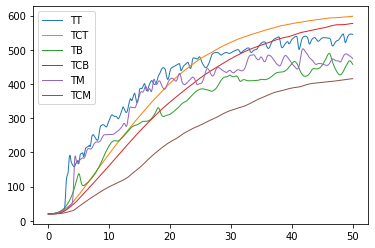

In [214]:
data_root = root + 'data/heat_transfer'
sim = fdsreader.Simulation(data_root)
time = sim.devices['Time'].data
# tc_1_1 = sim.devices[f'TC_1_1'].data
# t_1_1 = sim.devices[f'T_1_1'].data
# tc_1_2 = sim.devices[f'TC_1_2'].data
# t_1_2 = sim.devices[f'T_1_2'].data
# tc_1_3 = sim.devices[f'TC_1_3'].data
# t_1_3 = sim.devices[f'T_1_3'].data


# plt.figure(figsize=(8,8))
# plt.plot(time, tc_1_1, label="TC_1_1")
# plt.plot(time, t_1_1, label="T_1_1")
# plt.plot(time, tc_1_2, label="TC_1_2")
# plt.plot(time, t_1_2, label="T_1_2")
# plt.plot(time, tc_1_3, label="TC_1_3")
# plt.plot(time, t_1_3, label="T_1_3")

tst = sim.devices['Temp_steel_top'].data
tsb = sim.devices['Temp_steel_bottom'].data
tat = sim.devices['Temp_alu_top'].data
tab = sim.devices['Temp_alu_bottom'].data

tt = sim.devices['T_top'].data
tct = sim.devices['TC_top'].data
tb = sim.devices['T_bottom'].data
tcb = sim.devices['TC_bottom'].data
tm = sim.devices['T_middle'].data
tcm = sim.devices['TC_middle'].data

plt.plot(time, tt, label="TT")
plt.plot(time, tct, label="TCT")
plt.plot(time, tb, label="TB")
plt.plot(time, tcb, label="TCB")
plt.plot(time, tm, label="TM")
plt.plot(time, tcm, label="TCM")

# plt.plot(time, tst, label="TST")
# plt.plot(time, tat, label="TAT")
# plt.plot(time, tab, label="TAB")
# plt.plot(time, tsb, label="TSB")

plt.legend(loc='best')

# plt.xlabel("X / m")
# plt.ylabel("Z / m")
# plt.savefig('figs/pool_fire_1mw_temperatures_slice.svg', bbox_inches='tight')
# plt.close()



Slice([2D] cell_centered=True, extent=Extent([0.00, 0.00] x [0.00, 1.80] x [0.00, 4.80]), extent_dirs=('y', 'z'), orientation=1)


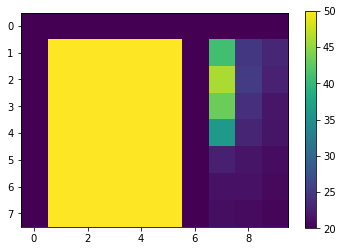

In [213]:
print(sim.slices[0])
time = 100
time_index = sim.slices[0].get_nearest_timestep(time)

slice_1 = sim.slices[1][0].data[time_index]
slice_2 = sim.slices[2][0].data[time_index]
plt.imshow(slice_2, vmax=50)
plt.colorbar()

:::{figure-md} fig-pool-fire-temp-slice

<img src="figs/pool_fire_1mw_temperatures_slice.svg" width="60%">

Visualization of the instantaneous ($\sf t=19.63~s$) `TEMPERATURE` values in the y-z-slice $\sf y=0~m$ with python / matplotlib. The data was obtained via the **fdsreader**.
:::

In [3]:
from fdsreader.bndf.utils import sort_patches_cartesian
data_root = root + 'data/pool_fire/bndf'
sim = fdsreader.Simulation(data_root)
obst = sim.obstructions[0]

orientation = -1
quantity = "AST"
patches = list()
for sub_obst in obst.filter_by_orientation(orientation):
    # Get boundary data for a specific quantity
    sub_obst_data = sub_obst.get_data(quantity)
    patches.append(sub_obst_data.data[orientation])

# Combine patches to a single face for plotting
patches = sort_patches_cartesian(patches)

shape_dim1 = sum([patch_row[0].shape[0] for patch_row in patches])
shape_dim2 = sum([patch.shape[1] for patch in patches[0]])
n_t = patches[0][0].n_t  # Number of timesteps

face = np.empty(shape=(n_t, shape_dim1, shape_dim2))
dim1_pos = 0
dim2_pos = 0
for patch_row in patches:
    d1 = patch_row[0].shape[0]
    for patch in patch_row:
        d2 = patch.shape[1]
        face[:, dim1_pos:dim1_pos + d1,
        dim2_pos:dim2_pos + d2] = patch.data
        dim2_pos += d2
    dim1_pos += d1
    dim2_pos = 0

t = 20
plt.figure(figsize=(4,6))
plot = plt.imshow(face[t].T, vmin=20, vmax=300, origin="lower", cmap="jet")
plt.colorbar(label="Temperature / $\sf ^\circ C$")
plt.xlabel("$\sf N_{cells,x}$ / -")
plt.ylabel("$\sf N_{cells,y}$ / -")
plt.savefig('figs/pool_fire_bndf_ast.svg', bbox_inches='tight')
plt.close()

**2. Solution**

In [4]:
data_root = root + 'data/pool_fire/10mw_sealed'
sim = fdsreader.Simulation(data_root)# Vector Plots
time = 20
time_index = slice_temp.get_nearest_timestep(time)


slice_u = sim.slices[3][0].data[time_index]
slice_v = sim.slices[4][0].data[time_index]
n_x = slice_u.shape[0]
n_y = slice_u.shape[1]
x = range(n_x)
y = range(n_y)
X, Y = np.meshgrid(x, y)
slice_res = (slice_u**2 + slice_v**2)**1/2
plt.figure(figsize=(3,6))
plt.quiver(X,Y, slice_u.T, slice_v.T, slice_res.T,cmap='jet', clim=(0,50), scale=100)
plt.colorbar(label = "Velocity / $\sf ms^{-2}$")
plt.xlabel("$\sf N_{cells,x}$ / -")
plt.ylabel("$\sf N_{cells,y}$ / -")
plt.xticks(ticks=[0,12.5,25], labels=[-2.5,0,2.5])
plt.yticks(ticks=[0,10,20,30,40,50], labels=[0,2,4,6,8,10])
plt.xlim(0,25)
plt.savefig('figs/pool_fire_velocity_vector_sealed.svg', bbox_inches='tight')
plt.close()

In [5]:
data_root = root + 'data/pool_fire/10mw_open'
sim = fdsreader.Simulation(data_root)# Vector Plots
time = 20
time_index = slice_temp.get_nearest_timestep(time)


slice_u = sim.slices[3][0].data[time_index]
slice_v = sim.slices[4][0].data[time_index]
n_x = slice_u.shape[0]
n_y = slice_u.shape[1]
x = range(n_x)
y = range(n_y)
X, Y = np.meshgrid(x, y)
slice_res = (slice_u**2 + slice_v**2)**1/2
plt.figure(figsize=(3,6))
plt.quiver(X,Y, slice_u.T, slice_v.T, slice_res.T,cmap='jet', clim=(0,50), scale=100)
plt.colorbar(label = "Velocity / $\sf ms^{-2}$")

plt.xlabel("$\sf N_{cells,x}$ / -")
plt.ylabel("$\sf N_{cells,y}$ / -")
plt.xticks(ticks=[0,12.5,25], labels=[-2.5,0,2.5])
plt.yticks(ticks=[0,10,20,30,40,50], labels=[0,2,4,6,8,10])
plt.xlim(0,25)
plt.savefig('figs/pool_fire_velocity_vector_open.svg', bbox_inches='tight')
plt.close()


```{tabbed} 10 MW, sealed domain
<img src="figs/pool_fire_velocity_vector_sealed.svg" width="60%">
```

```{tabbed} 10 MW, open domain
<img src="figs/pool_fire_velocity_vector_open.svg" width="60%">
```

**3. Solution**

The fluctuation of the HRR curve increases at higher levels. A drop in the released energy with time indicates a lower oxygen level due to the sealed compartment.

In [6]:
data_root = root + 'data/pool_fire/100kw_sealed'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='simulation')
t_min_max = [sim.hrr["Time"][0], sim.hrr["Time"][-1]]
hrr_prescribed = 100
plt.plot(t_min_max, [hrr_prescribed, hrr_prescribed], label='prescribed')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.xlabel("Time / s")
plt.ylabel("HRR / kW")
plt.savefig('figs/pool_fire_100kw_sealed_hrr.svg', bbox_inches='tight')
plt.close()

In [7]:
data_root = root + 'data/pool_fire/1mw_sealed'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='simulation')
t_min_max = [sim.hrr["Time"][0], sim.hrr["Time"][-1]]
hrr_prescribed = 1000
plt.plot(t_min_max, [hrr_prescribed, hrr_prescribed], label='prescribed')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.xlabel("Time / s")
plt.ylabel("HRR / kW")
plt.savefig('figs/pool_fire_1mw_sealed_hrr.svg', bbox_inches='tight')
plt.close()

In [8]:
data_root = root + 'data/pool_fire/10mw_sealed'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='simulation')
t_min_max = [sim.hrr["Time"][0], sim.hrr["Time"][-1]]
hrr_prescribed = 10000
plt.plot(t_min_max, [hrr_prescribed, hrr_prescribed], label='prescribed')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.xlabel("Time / s")
plt.ylabel("HRR / kW")
plt.savefig('figs/pool_fire_10mw_sealed_hrr.svg', bbox_inches='tight')
plt.close()


```{tabbed} 100 kW
<img src="figs/pool_fire_100kw_sealed_hrr.svg" width="80%">
```

```{tabbed} 1 MW
<img src="figs/pool_fire_1mw_sealed_hrr.svg" width="80%">
```

```{tabbed} 10 MW
<img src="figs/pool_fire_10mw_sealed_hrr.svg" width="80%">
```

## Task II - Plume Formulas

This task targets the computation of the plume temperature with analytical methods in order to subsequently validate the results of an numerical simulation. For more detailed information on the theory and application of the plume formulas, please refer to the literature, e.g. Enclosure Fire Dynamics by B. Karlsson and J. Quintiere {cite}`Karlsson.1999`.

***Heskested***

$\small\sf \Delta T $ indicates the temperature rise in the plume centerline axis above ambient temperature:


$$ \small\sf
\Delta T = 9.1 \left(\frac{T_\infty}{g \cdot c_p^2 \cdot \rho_\infty^2} \right)^{1/3} \cdot \dot{Q}_c^{2/3} \cdot (z -z_0)^{-5/3}
$$

where $\sf \dot{Q}_c$ is the convective heat release rate, $\small\sf T_\infty = 293~K$ is the ambient temperature, $\small\sf g = 9.81~ms^{-1}$ is the gravitational constant, $\small\sf \rho_\infty = 1.2 kg/m^3$ is the 
density of air at ambient temperature, $\small\sf c_p = 1.0~kJ/(kg K)$ is the specific heat capacity and z is the height above the fuel source in m.

The virtual origin $\small\sf z_0$ depends on the (equivalent) diameter D of the fire source and the total heat release rate and is given by:

$$\small\sf
z_0 = 0.083 \cdot \dot{Q}^{2/5} - 1.02 \cdot D
$$

The calculation of the plume temperature according to Heskestad is defined exclusively for the area above the flame. The flame height is calculated by the following expression: 

$$\small\sf
L = 0.235 \cdot \dot{Q}^{2/5} - 1.02 \cdot D
$$

***McCaffrey***

$\small\sf \Delta T $ indicates the temperature rise in the plume centerline axis above ambient temperature:

$$\small\sf
\Delta T = \left(\frac{\kappa}{0.9 \cdot \sqrt{2g}}\right)^2 \cdot \left(\frac{z}{\dot{Q}^{2/5}}\right)^{2\eta-1} \cdot T_\infty
$$

where $\small\sf \dot{Q}$ is the total heat release rate, $\small\sf T_\infty = 293~K$ is the ambient temperature, $\small\sf g = 9.81~ms^{-1}$ is the gravitational constant, z is the height above the fuel source in m. The constants $\small\sf \eta$ and $\small\sf \kappa$ vary depending on the plume regions and can be obtained from the following table.

| Region       | $ \small\sf \frac{z}{\dot{Q}^{2/5}}$    | $\small\sf \eta$ | $\small\sf \kappa$           |
|--------------|---------------------|--------|-----------------------------|
| Continuous   | < 0.08           | 1/2  | $\small\sf 6.8~[m^{1/2}/s]$           |
| Intermittent | 0.08-0.2         |  0    | $\small\sf 1.9~[m/(kW^{1/5}s)]$       |
| Plume        | > 0.2            | -1/3 | $\small\sf 1.1~[m^{4/4}/(kW^{1/3}s)]$ |

**Task:**

1. Calculate the temperatures of the plume within the respective application limits using the analytical approaches of the Heskested and Mccaffrey Plumes with a HRR of 1 MW at heights of $\small\sf  z = 1~m, 2~m, 3~m, 4~m, 5~m, 6~m$. Assume that the radiative fraction of the plume is 20 % and $ \small\sf A_{fire}=1~m^2$ . Compare the results and discuss the reasons for the deviations.

2. Compare the results from the analytical calculations to the results of an FDS simulation using temperature devices. Smooth the output by a moving average to reduce noise. Refer to section 20.1 of the [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf) for further information on how to place Devices in the computational domain.

    Add the following lines to your FDS file to open the lateral and top boundaries of the sealed domain which provides a better depiction of the boundary conditions of the empirically determined plume formulas:
    ```
    &VENT MB = 'XMIN' SURF_ID = 'OPEN' /
    &VENT MB = 'XMAX' SURF_ID = 'OPEN' /
    &VENT MB = 'YMIN' SURF_ID = 'OPEN' /
    &VENT MB = 'YMAX' SURF_ID = 'OPEN' /
    &VENT MB = 'ZMAX' SURF_ID = 'OPEN' /
    ``` 
    
```{tip} To reduce noise, temperatures calculated with FDS can be smoothed using a simple moving average (SMA). The SMA of a time series $\small\sf x(t)$ is the sequence of arithmetic averages of $\small\sf  n$ consecutive data points.
$\small\sf m_{SMA}(t) = \frac{1}{n}\sum_{i=0}^{n-1}x(t-i)$
```
**1. Solution:**

***Heskested***
```{toggle}
Simplifying the plume formula into:

$\small\sf \Delta T = 9.1 \left(\frac{T_\infty}{g \cdot c_p^2 \cdot \rho_\infty^2} \right)^{1/3} \cdot \dot{Q}_c^{2/3} \cdot (z -z_0)^{-5/3} = 25 \left( \frac{\dot{Q}_c^{2/5}}{(z -z_0)}\right)^{5/3}$

The equivalent diameter:

$\small\sf D = \sqrt{\frac{4 \cdot A}{\pi}} = \sqrt{\frac{4 \cdot 1}{\pi}} \approx 1.13~m$

The virtual plume origin:

$\small\sf z_0 = 0.083 \cdot 1000^{2/5} - 1.02 \cdot 1.13 \approx 0.163~m$

The flame height:

$\small\sf L = 0.235 \cdot 1000^{2/5} - 1.02 \cdot 1.13 = 2.57~m$

The plume temperature at different heights:

$\small\sf z = 3.0 m:$ $\small\sf  \Delta T = 25 \left( \frac{800^{2/5}}{(3 - 0.163)}\right)^{5/3} = 379~K$

$\small\sf z = 4.0 m:$ $\small\sf  \Delta T = 25 \left( \frac{800^{2/5}}{(4 - 0.163)}\right)^{5/3} = 229~K$

$\small\sf z = 5.0 m:$ $\small\sf  \Delta T = 25 \left( \frac{800^{2/5}}{(5 - 0.163)}\right)^{5/3} = 156~K$

$\small\sf z = 6.0 m:$ $\small\sf  \Delta T = 25 \left( \frac{800^{2/5}}{(6 - 0.163)}\right)^{5/3} = 114~K$

```

***McCaffrey***

```{toggle}
$\small\sf z = 1.0 m: \frac{z}{\dot{Q}^{2/5}} = \frac{1}{1000^{2/5}} = 0.063~|~0.063 < 0.08$ -> Continuous

$\small\sf z = 2.0 m: \frac{z}{\dot{Q}^{2/5}} = \frac{2.0}{1000^{2/5}} = 0.126~|~0.2 > 0.126 > 0.08$ -> Intermediate

$\small\sf z = 3.0 m: \frac{z}{\dot{Q}^{2/5}} = \frac{3.0}{1000^{2/5}} = 0.189~|~0.2 > 0.189 > 0.08$ -> Intermediate

$\small\sf z = 4.0 m: \frac{z}{\dot{Q}^{2/5}} = \frac{4.0}{1000^{2/5}} = 0.252~|~0.252 > 0.2$ -> Plume

$\small\sf z = 5.0 m: \frac{z}{\dot{Q}^{2/5}} = \frac{5.0}{1000^{2/5}} = 0.315~|~0.315 > 0.2$ -> Plume

$\small\sf z = 6.0 m: \frac{z}{\dot{Q}^{2/5}} = \frac{6.0}{1000^{2/5}} = 0.379~|~0.379 > 0.2$ -> Plume


The calculated temperatures and the respective auxiliary constants used can be found in the following table:


| $\small\sf z [m]$ | $\small\sf \frac{z}{\dot{Q}^{2/5}}[m/kW^{2/5}]$  | $\small\sf \eta$ | $\small\sf \kappa$             | $\small\sf \Delta T [\circ C]$ |
|:-------:|:--------------------------------------:|:------:|:--------------------:|:--------------------:|
| 1.0     | 0.063                                  | 1/2    | $\small\sf 6.8~m^{1/2}/s$      |          852         |
| 2.0     | 0.126                                  | 0      | $\small\sf 1.9~m/(kW^{1/5}s)$  |          528         |
| 3.0     | 0.189                                  | 0      | $\small\sf 1.9~m/(kW^{1/5}s)$  |          352         |
| 4.0     | 0.252                                  | -1/3   | $\small\sf 1.1~m^{4/4}/(kW^{1/3}s)$   |          221         |
| 5.0     | 0.315                                  | -1/3   | $\small\sf 1.1~m^{4/4}/(kW^{1/3}s)$  |          152         |
| 6.0     | 0.379                                  | -1/3   | $\small\sf 1.1~m^{4/4}/(kW^{1/3}s)$  |          113         |

```

***FDS Devices***

In [21]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


def sma (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma
d_t_hesk_dict = {3.0:379, 4.0:229, 5.0:156, 6:114}
d_t_mcf_dict = {1.0:852, 2.0:527, 3.0:352, 4.0:221, 5.0:152, 6.0:112}
color_list = ['b', 'c', 'g', 'r', 'y', 'm']
data_root = root + 'data/pool_fire/1mw_open'
sim = fdsreader.Simulation(data_root)
height_list = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
window = 100
for z, c in zip(height_list, color_list):
    time = sim.devices['Time'].data
    temperature = sim.devices[f'T_{z}'].data
#     plt.scatter(time, temperature, s=1, alpha=0.1, color=c)
    plt.plot(sma(time, window), sma(temperature, window), label=f"z = {z}", color=c)
    if z in d_t_hesk_dict:
        plt.axhline(y=d_t_hesk_dict[z]+20, color=c, linestyle='dashed')
    if z in d_t_mcf_dict:
        plt.axhline(y=d_t_mcf_dict[z]+20, color=c, linestyle='dotted')
    plt.annotate(f"$\sf z={z}~m$", xy=(30, d_t_mcf_dict[z]-50),  color=c, annotation_clip=False)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.xlabel("Time / s")
plt.ylabel("Temperature / $\sf ^\circ C$")
line_fds = Line2D([0], [0], color='black', linestyle='-')
line_hesk = Line2D([0], [0], color='black', linestyle='dashed')
line_mcf = Line2D([0], [0], color='black', linestyle='dotted')
plt.legend([line_fds, line_hesk, line_mcf], ["FDS", "Heskestad", "MCCaffrey"])

plt.savefig('figs/pool_fire_1mw_open_temperatures_devc.svg', bbox_inches='tight')
plt.close()

**2. Solution**
:::{figure-md} fig-pool-fire-hrr

<img src="figs/pool_fire_1mw_open_temperatures_devc.svg" width="80%">

Moving average of `TEMPERATURE` devices at heights 1.0, 2.0, 3.0, 4.0, 5.0 and 6.0 m smoothed over 100 datapoints.
:::

## Task III – Time-dependent Heat Release Rate

This task deals with the different possibilities to define the heat release rate (HRR) of a design fire and to model it in FDS. The total heat release  $\small\sf \dot{Q}$ of a burning area $\small\sf A_{fire}$ depends on the heat release rate per unit area $\small\sf \dot{q}''$:

$$\small\sf \dot{Q} = {A_{Fire} \cdot \dot{q}''}$$
In FDS a burning area is defined by a `VENT` with a certain surface property that can be assigned by a `SURF_ID`. A fixed heat release rate per unit area can be set to a `SURF` by the attribute `HRRPUA`. Please refer to section 10.2.1 "Basics" of the [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf) for further information.

```{tip} Create an automation in Python or Excel that outputs the strings of the RAMP lines for the FDS input file.  
```

**Task:**

1. Model the HRR progression for a radially spreading fire with a maximum power of 1 MW in FDS assuming a fixed burning area (task 1.1) and a radial propagation from the center of the burning area (task 1.2).


    1. The HRR according to the 't-square' model can be described by:
    
        $$\small\sf \dot Q = \alpha \cdot t^2$$
        where t is the  burning time after ignition and $\small\sf \alpha$ is the fire growth factor.Assume a fast fire propagation by $\small\sf \alpha = 0.04689~kW/s^2$ and a **constant** heat release rate per unit area of $\small\sf  \dot{q}'' = 0.25~MW/m^2$. The maximum burning area is $\small\sf  A_{fire} = 1~m^2$. First calculate the time until the fire has spread to the entire area. This corresponds to the time at which the maximum HRR is reached. For simplicity, assume a perfect radial fire spread and a round fire area. Then model the temporal evolution of the HRR in FDS via a `RAMP` function (See section 20.6 "Controlling a Ramp" of the [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf) ).
    
    2. Model the fire propagation directly in FDS by defining the spread rate. The `SPREAD` attribute denotes a constant radial propagation speed from a specified point.
        :::{figure-md} fig-pool-fire-spread

        <img src="figs/pool_fire_spread.svg" width="30%">

        Fire propagation via FDS `SPREAD` attribute
        :::
    
        For instructions on how to model a radial fire spread in FDS, please refer to the [FDS User's Guide](https://github.com/firemodels/fds/releases/download/FDS6.7.5/FDS_User_Guide.pdf) Section 11.4.2 "Special Topic: A Radially-Spreading Fire". The radial propagation speed v can be obtained from the fire area $\small\sf A_{Fire}$ and the corresponding burning period t.
        
        $$\small\sf v = \frac{\sqrt{A_{fire}/\pi}}{t}$$

    3. Compare the HRR curves calculated by FDS with each other and discuss the limitations and inaccuracies associated with each approach.


2. Given is the fictional mass loss of a heptane fire. Calculate the heat release of the fire over the entire burning period with an assumed effective heat of combustion $\small\sf  \Delta h_{c,eff} = 44,590~kJ / kg$. Model the HRR in FDS by using the RAMP function. Check if the simulated curve matches the prescribed HRR. The effective heat of combustion indicates the heat release per unit of weight of a material burned in combustion. For simplicity, assume that the averaged mass loss between two time steps applies to the end of each time interval. 
The mass loss caused by the burn-up can be described by the following time-dependent correlation:
    ```
    time_index = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275 ] # [s]
    total_mass = [4000, 4000, 3600, 3040, 2880, 2400, 1800, 1120, 600, 160, 0, 0] # [g]
     ```

**1. Solution**
```{toggle}
The burning period for the fire to reach the maximum heat release is:

$$
t = \frac{\dot{q}'' \cdot A_{Fire}}{\alpha} = \frac{250 \cdot 1}{0.04689} \approx 73~s
$$

By setting the time and fraction parameters `T` and `F`, the `RAMP` function is obtained as follows:

    &SURF ID = 'BURNER', HRRPUA = 250, RAMP_Q = 'fireramp', COLOR = 'RASPBERRY' /
    &VENT XB = -0.5,0.5, -0.5,0.5, 0.0, 0.0, SURF_ID='BURNER' /
    &RAMP ID='fireramp', T=0, F=0.00
    .
    .
    .
    &RAMP ID='fireramp', T=73, F=1.00

The spread rate corresponds to the propagation speed in m/s:

$$
\small\sf v = \frac{\sqrt{A_{fire}/\pi}}{t} = \frac{\sqrt{1/\pi}}{73} = 0.00773 m/s
$$

Starting from the center of the vent, the radial propagation of the fire in FDS can be described as follows:

    &SURF ID = 'BURNER', HRRPUA = 250, COLOR = 'RASPBERRY' /
    &VENT XB = -0.5,0.5, -0.5,0.5, 0.0, 0.0, SURF_ID='BURNER', SPREAD_RATE = 0.00773 /
```

In [ ]:
alpha = 0.04689
Qdot_max = 250
t = (Qdot_max / alpha)**(1/2)
print(t)
print(f"&SURF ID = 'BURNER', HRRPUA = {Qdot_max}, RAMP_Q = 'fireramp', COLOR = 'RASPBERRY' /")
for t in range(0, 74):
    Qdot = alpha * t **2
    
    print(f"&RAMP ID='fireramp', T={t}, F={Qdot / Qdot_max:.2f}")

In [ ]:
data_root = root + 'data/pool_fire/ramp_spread/rundir'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='FDS SPREAD')
t_min_max = [sim.hrr["Time"][0], sim.hrr["Time"][-1]]

data_root = root + 'data/pool_fire/ramp_tsquare'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='FDS RAMP')
t_min_max = [sim.hrr["Time"][0], sim.hrr["Time"][-1]]

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.xlabel("Time / s")
plt.ylabel("HRR / kW")
plt.savefig('figs/pool_fire_10mw_sealed_hrr_spread.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-pool-fire-hrr-spread

<img src="figs/pool_fire_10mw_sealed_hrr_spread.svg" width="80%">

Simulated `HRR` generated by `RAMP` and `SPREAD` as a function of time.
:::

**2. Solution**
```{toggle}
The HRR can be obtained from the mass loss $\small\sf \dot{m_{fuel}}$ by the following expression:
$$\small\sf \dot{Q} = \Delta h_{c,eff} \dot{m_{fuel}}$$

The maximum 

    &SURF ID = 'BURNER', HRRPUA = 1212.85, RAMP_Q = 'fireramp', COLOR = 'RASPBERRY' /
    &RAMP ID='fireramp', T=0, F=0.00 /
    &RAMP ID='fireramp', T=25, F=0.15 /
    &RAMP ID='fireramp', T=50, F=0.59 /
    &RAMP ID='fireramp', T=75, F=0.68 /
    &RAMP ID='fireramp', T=100, F=0.35 /
    &RAMP ID='fireramp', T=125, F=0.59 /
    &RAMP ID='fireramp', T=150, F=0.88 /
    &RAMP ID='fireramp', T=175, F=1.00 /
    &RAMP ID='fireramp', T=200, F=0.76 /
    &RAMP ID='fireramp', T=225, F=0.65 /
    &RAMP ID='fireramp', T=250, F=0.24 /
    &RAMP ID='fireramp', T=275, F=0.00 /


```

In [ ]:
time_list = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275 ]
mass_list = [4000, 3900, 3500, 3040, 2800, 2400, 1800, 1120, 600, 160, 0, 0]
mlr_list = np.diff(mass_list)/np.diff(time_list) # mass loss rate

huc = 44590 # Effective heat of combustion huc = 44590 KJ / kg
hrr_list =abs(mlr_list/1000*huc) # calculate HRR from mass loss
hrr_list = np.concatenate(([0], hrr_list)) # add 0 mass at first timestep
print(hrr_list)
print(f"&SURF ID = 'BURNER', HRRPUA = {max(hrr_list):.2f}, RAMP_Q = 'fireramp', COLOR = 'RASPBERRY' /")
for time, hrr in zip(time_list, hrr_list):
    print(f"&RAMP ID='fireramp', T={time}, F={hrr/max(hrr_list):.2f} /")

In [ ]:
# Plot HRR from Simulation
data_root = root + 'data/pool_fire/ramp_heptane/rundir'
sim = fdsreader.Simulation(data_root)
plt.plot(sim.hrr["Time"], sim.hrr["HRR"], label='simulation')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Time / s")
plt.ylabel("HRR / kW")
# Plot prescribed data
plt.plot(time_list, hrr_list, label = 'prescribed')
plt.legend(loc='best')
plt.savefig('figs/pool_fire_hrr_heptane_ramp.svg', bbox_inches='tight')
# plt.close()

:::{figure-md} fig-pool-fire-hrr-ramp

<img src="figs/pool_fire_hrr_heptane_ramp.svg" width="80%">

Prescribed and simulated `HRR` of n-heptane fire as a function of time. The heat release can be derived from the mass loss and the effective heat of combustion $\small\sf \Delta h_{c,eff}$.
:::

## Task IV – Grid Convergence / HPC computing / Benchmarking

This task deals with the monitoring of simulation parameters such as computation time and the convergence of numerical solutions. 

**Task:**

1. Increase / decrease the grid resolution by factors of 0.4 and 2. Monitor the computing time by evaluating the .out file.

2. Extend the examination by refining the grid by a factor of 4 and 8, using resources of parallel computing. For this purpose subdivide the computational domain into several meshes.

3. Analyze the computation time for assigning multiple cores to a single OpenMP process. Split the computational domain into different meshes and assign individual MPI processes to each of them. Try to combine MPI and OpenMP and evaluate the increase in performance.

4. Check grid convergence for the respective resolutions of the domain based on temperature and velocity criteria

**Solution:**

In [ ]:
import pandas as pd
data_root = root + 'data/pool_fire/gc_3_1/rundir'
caselist = ['gc_1_1', 'gc_1_2', 'gc_1_3', 'gc_2_1', 'gc_2_2', 'gc_2_3', 'gc_3_1', 'gc_3_2', 'gc_3_3' ]
bm_dict = {}
for case in caselist:
    case_dict = {}
    data_root = root + f'data/pool_fire/{case}/rundir'
    sim = fdsreader.Simulation(data_root)
    case_dict['devc_temp'] = sim.devices[f'T_{1.0}'].data
    case_dict['sim_time'] = sim.devices['Time'].data
    case_dict['total_time'] = sim.cpu['Total T_USED (s)\n'][0]
    out_file = sim.out_file_path
    with open(out_file, 'r') as file:
        for line in file:
            if 'Total Number of Grid Cells' in line:
                case_dict['n_cells'] = int(line.split('Cells')[-1])
            if 'Number of OpenMP Threads:' in line:
                case_dict['n_open_mp'] = int(line.split('Number of OpenMP Threads:')[-1])
            if 'Number of MPI Processes:' in line:
                case_dict['n_mpi']= int(line.split('Number of MPI Processes:')[-1])
    
    bm_dict[case] = case_dict
bm_df = pd.DataFrame(bm_dict).T

for n_open_mp in [1,2,4]:
    df = bm_df[bm_df['n_open_mp']==n_open_mp]
    plt.plot(df['n_cells'], df['total_time'], label=f"$\sf N_{{openMP}}$ = {n_open_mp}")
plt.xscale('log')
# plt.yscale('log')
plt.xlabel("$\sf N_{{cells}}$ / -")
plt.ylabel("Time / s")
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.savefig('figs/pool_fire_benchmarking.svg', bbox_inches='tight')

In [ ]:
window = 10
for n_cells in [2000, 31250, 250000]:
    time = bm_df[bm_df['n_cells']==n_cells].iloc[0]['sim_time']
    temp = bm_df[bm_df['n_cells']==n_cells].iloc[0]['devc_temp']
    plt.plot(sma(time, window), sma(temp, window), label=f"$\sf N_{{cells}}$ = {n_cells}")
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend(loc='lower right')
plt.xlabel("Time / s")
plt.ylabel("Temperature / $\sf ^\circ C$")
plt.savefig('figs/pool_fire_grid_convergence.svg', bbox_inches='tight')
plt.close()

:::{figure-md} fig-pool-fire-benchmarking

<img src="figs/pool_fire_benchmarking.svg" width="80%">

Total computation time as a function of the total number of grid cells in the computational domain ( $\sf N_{cells}$ ) for different amount of openMP processes ($\sf N_{openMP}$). 
:::
 

:::{figure-md} fig-pool-fire-grid-convergence

<img src="figs/pool_fire_grid_convergence.svg" width="80%">

Checking grid convergence for a device with quantity `TEMPERATURE` at XYZ (0, 0, 1). A grid size of 20 cm and below, which results in a total number of 31250 cells, does not show any significant change in temperature.
:::